# Give Me Some Credit Project

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. The goal of this project is to build a model that borrowers can use to help make the best financial decisions.

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import pickle
import os
import pathlib as pt

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# ML
from lazypredict.Supervised import LazyClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model._logistic import LogisticRegressionCV
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.ensemble._gb import GradientBoostingClassifier
from sklearn.svm._classes import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Display
pd.options.display.float_format = '{:.2f}'.format



| Variable Name                           | Description                                                                                                      | Type      |
|---------------------------------------- |-----------------------------------------------------------------------------------------------------------------|-----------|
| SeriousDlqin2yrs                       | Person experienced 90 days past due delinquency or worse                                                         | Y/N       |
| RevolvingUtilizationOfUnsecuredLines    | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits   | percentage|
| age                                    | Age of borrower in years                                                                                        | integer   |
| NumberOfTime30-59DaysPastDueNotWorse   | Number of times borrower has been 30-59 days past due but no worse in the last 2 years.                         | integer   |
| DebtRatio                              | Monthly debt payments, alimony, living costs divided by monthly gross income                                    | percentage|
| MonthlyIncome                          | Monthly income                                                                                                   | real      |
| NumberOfOpenCreditLinesAndLoans        | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)            | integer   |
| NumberOfTimes90DaysLate                | Number of times borrower has been 90 days or more past due.                                                      | integer   |
| NumberRealEstateLoansOrLines           | Number of mortgage and real estate loans including home equity lines of credit                                  | integer   |
| NumberOfTime60-89DaysPastDueNotWorse   | Number of times borrower has been 60-89 days past due but no worse in the last 2 years.                         | integer   |
| NumberOfDependents                     | Number of dependents in family excluding themselves (spouse, children etc.)                                     | integer   |


In [2]:
cwd = pt.Path.cwd()
df_train = pd.read_csv(cwd / 'data' / 'cs-training.csv', index_col=0)
df_test = pd.read_csv(cwd / 'data' / 'cs-test.csv', index_col=0)

In [3]:
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.77,45,2,0.80,9120.00,13,0,6,0,2.00
2,0,0.96,40,0,0.12,2600.00,4,0,0,0,1.00
3,0,0.66,38,1,0.09,3042.00,2,1,0,0,0.00
4,0,0.23,30,0,0.04,3300.00,5,0,0,0,0.00
5,0,0.91,49,1,0.02,63588.00,7,0,1,0,0.00


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

We have null values for MonthlyIncome and NumberOfDependents.

In [5]:
df_train.SeriousDlqin2yrs.mean() 

0.06684

Train Data is heavily imbalanced, as only approximately 6% of people have defaulted. Let's have a look at the variables.

To do that, we start removing outliers with a BoxPlot/IQR approach in order to understand better the variables' distribution.

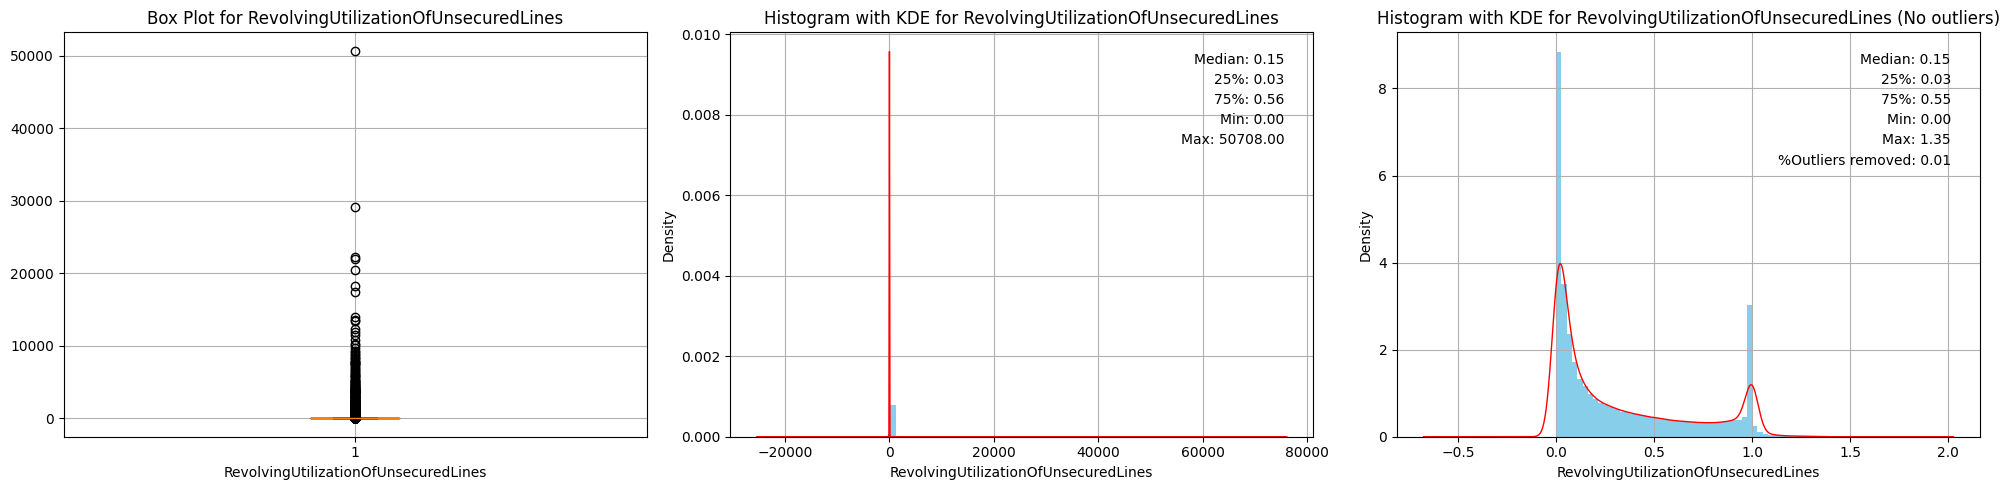

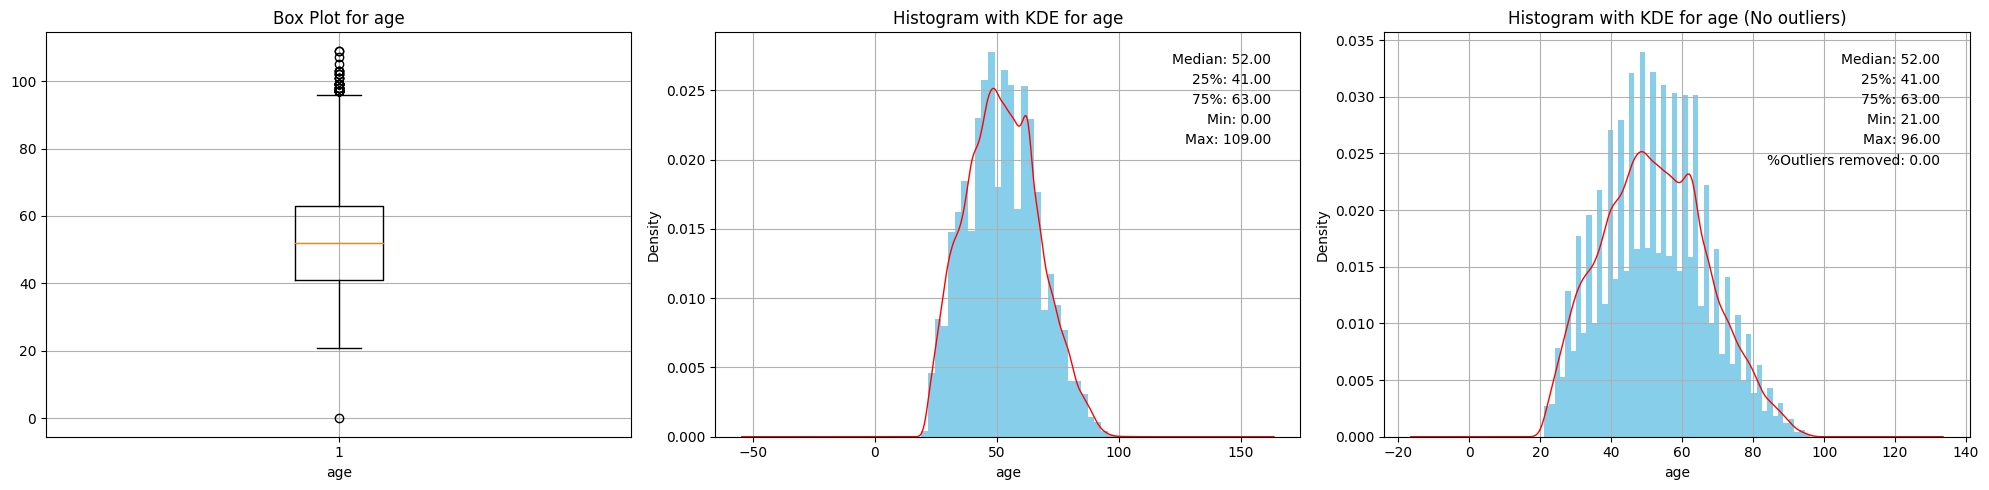

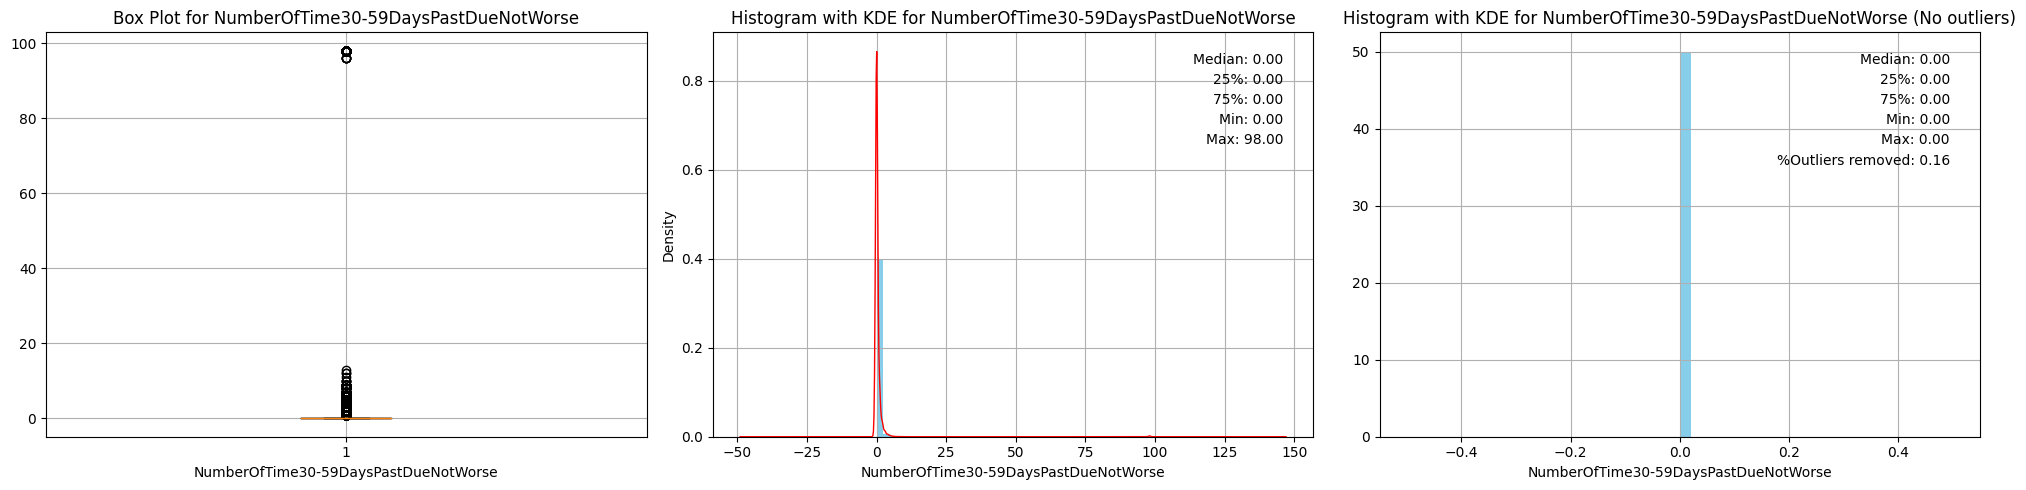

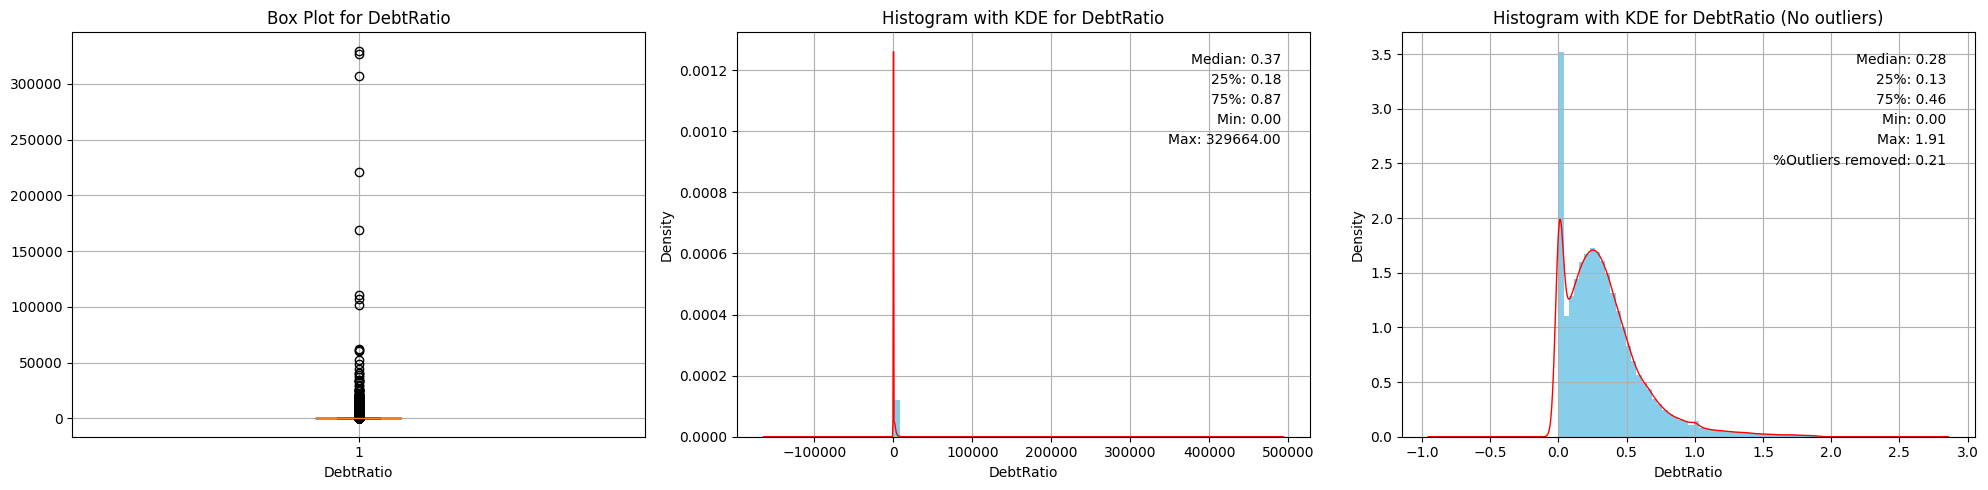

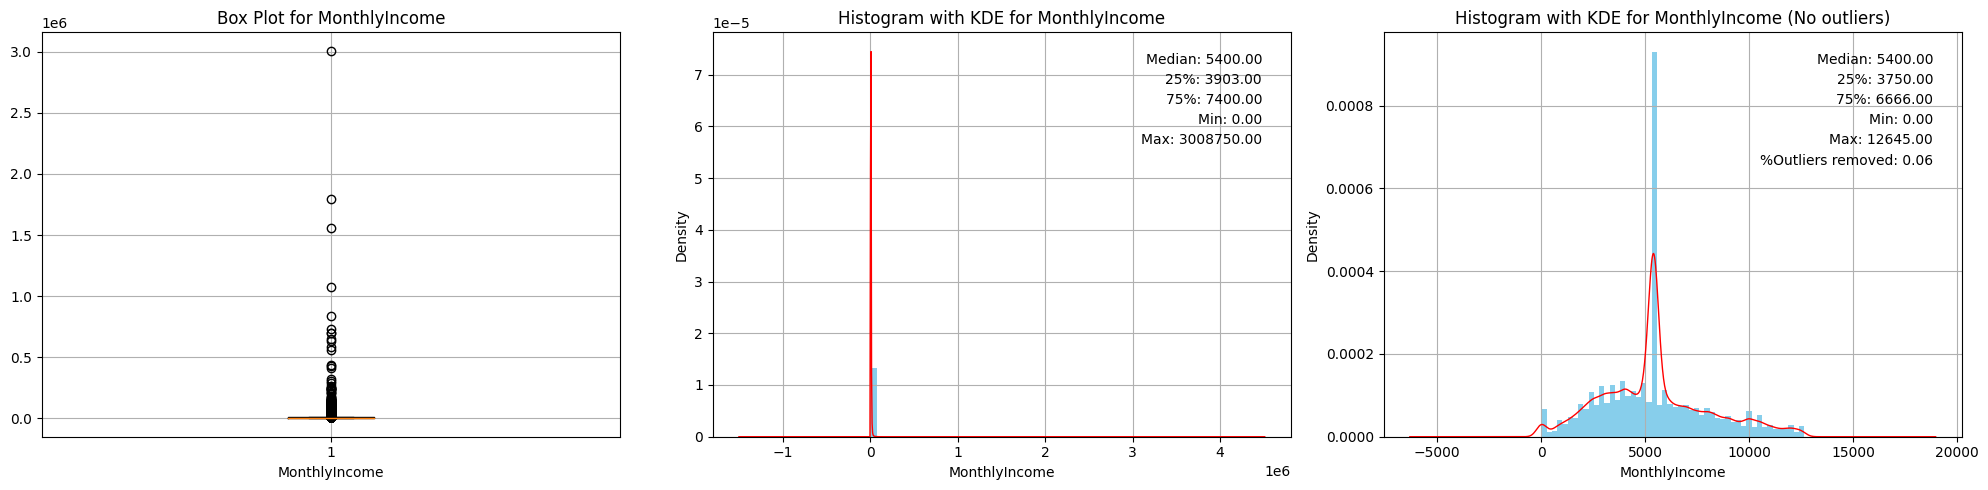

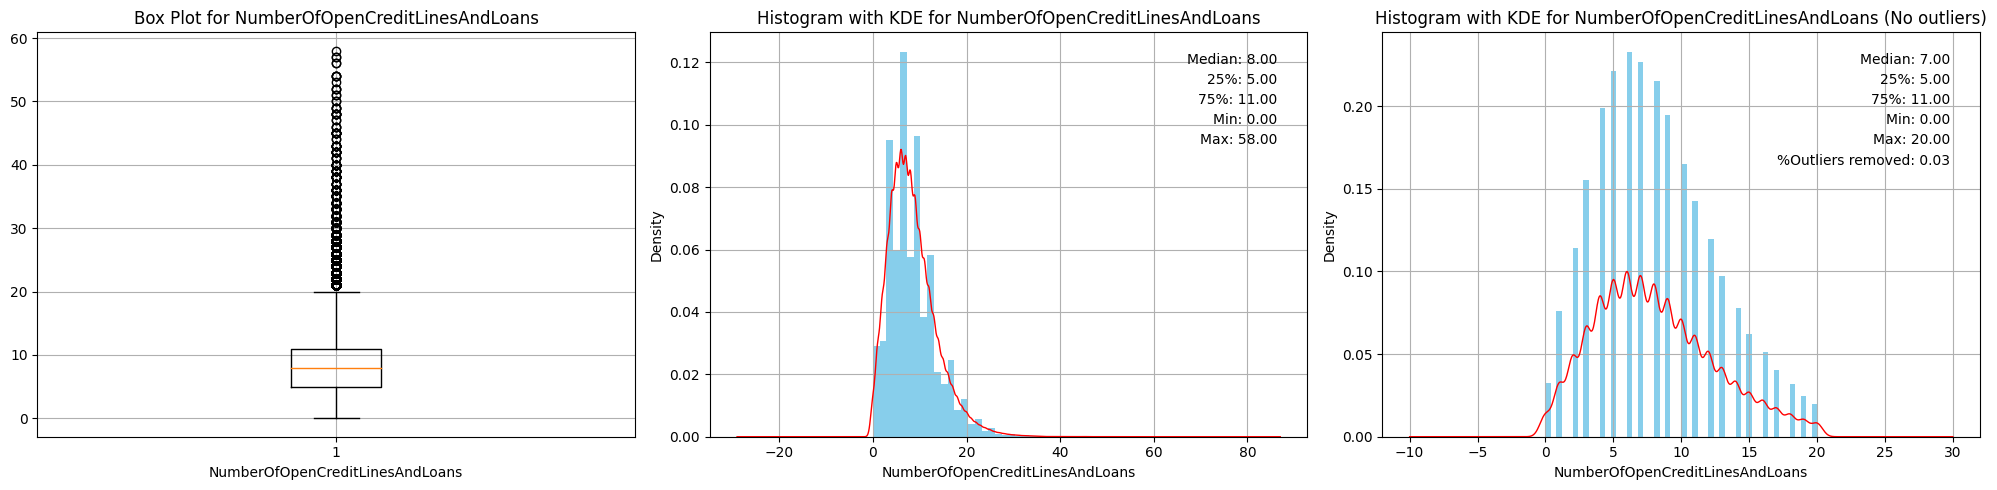

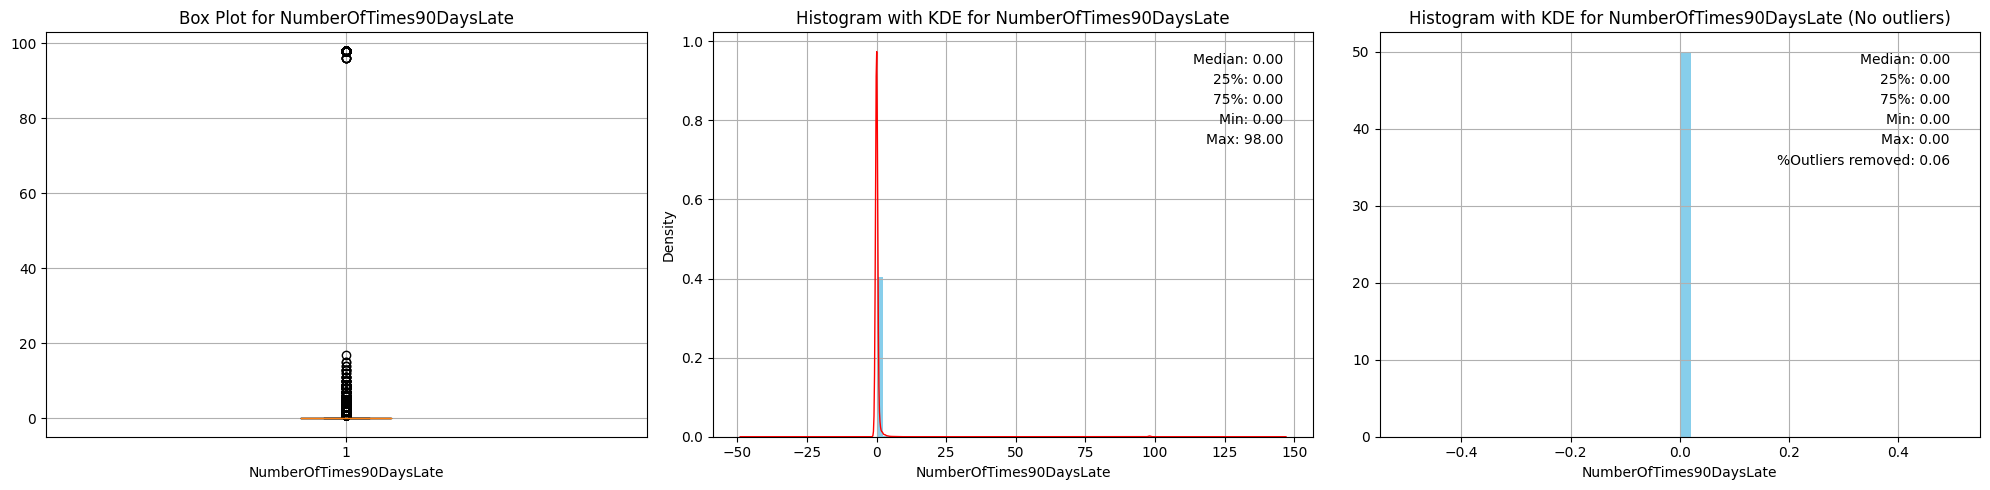

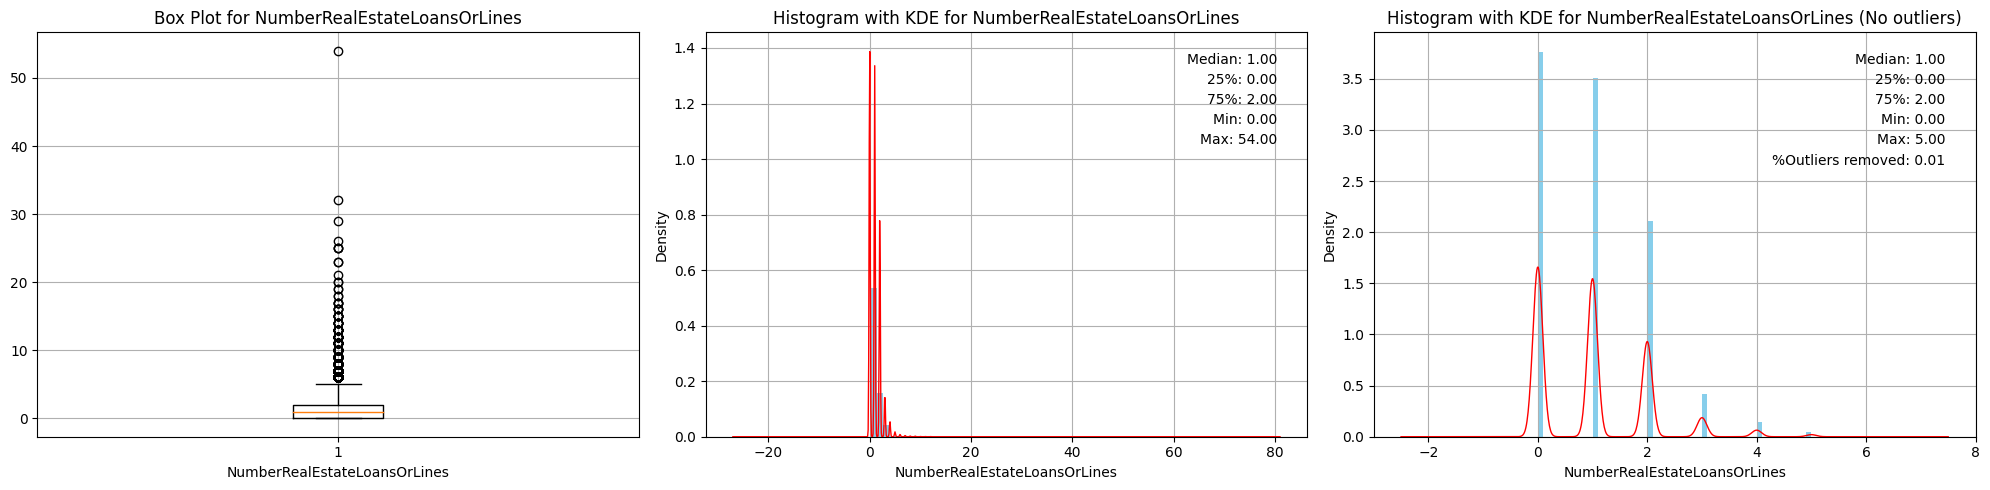

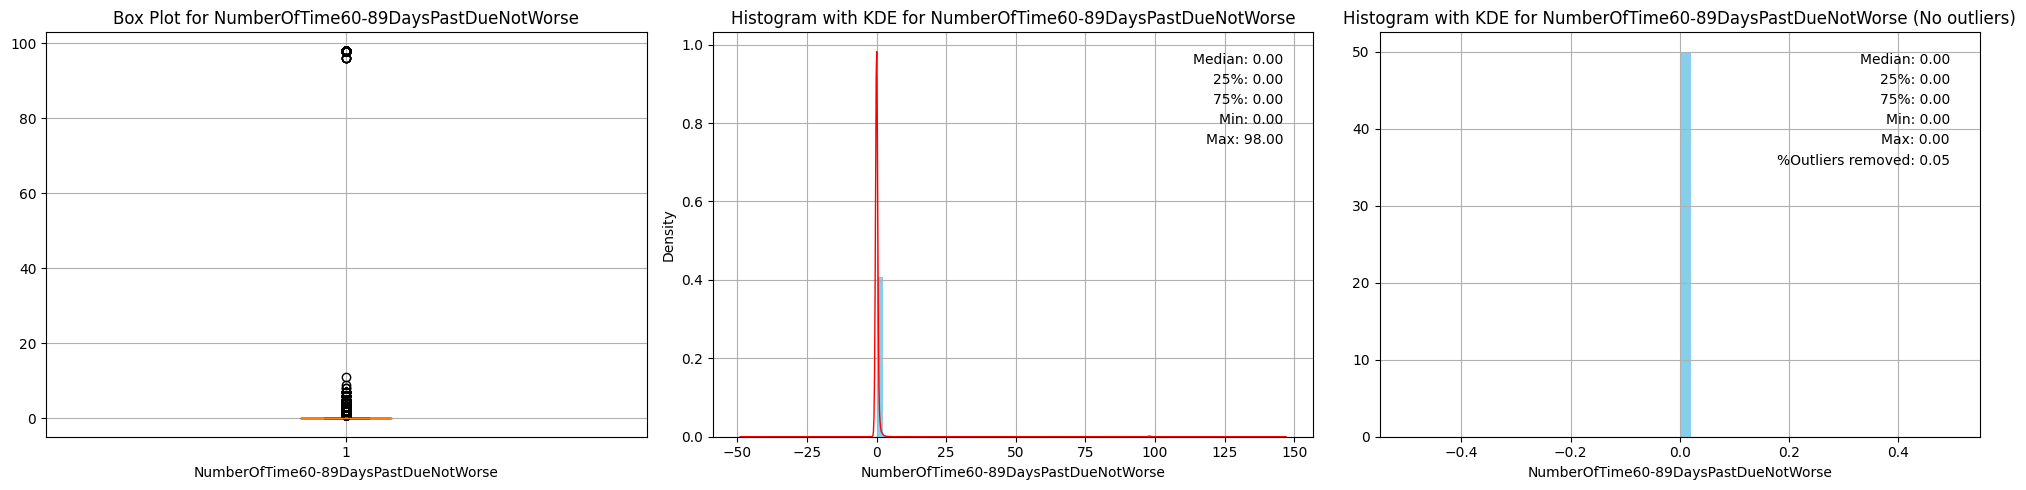

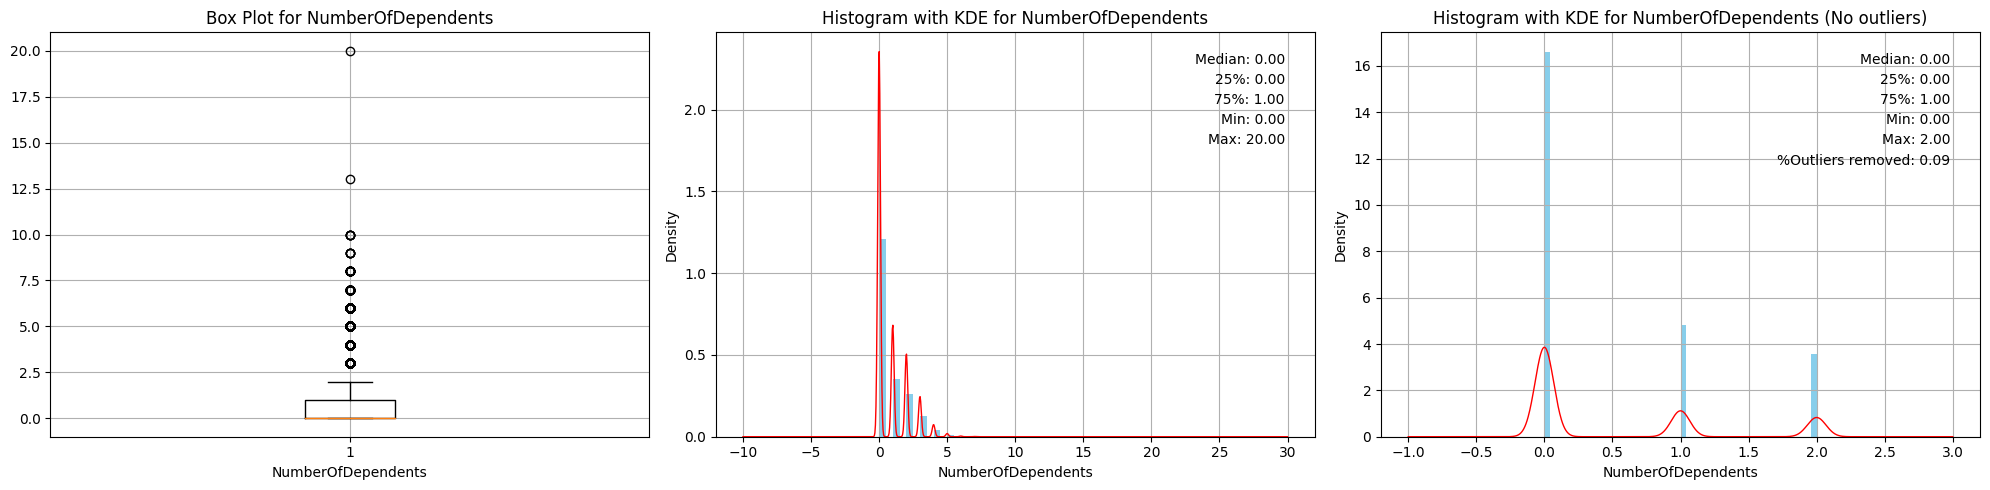

In [6]:
# Plotting boxplots and empirical distributions
outlier_indexes = []

for col in df_train.columns[1:]:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Feature
    s = df_train[col].fillna(df_train[col].median()) # at the moment we fill it just to obtain plots (we have nan only for 2 variables
    
    # Boxplot
    axes[0].boxplot(s)
    axes[0].set_title(f'Box Plot for {col}')
    axes[0].set_xlabel(col)
    axes[0].grid(True)

    # Histogram with KDE
    axes[1].hist(s, bins=40, color='skyblue', density=True)
    s.plot(kind='kde', ax=axes[1], color='red', linewidth=1)
    axes[1].set_title(f'Histogram with KDE for {col}')
    axes[1].set_xlabel(col)
    axes[1].grid(True)
    axes[1].text(0.95, 0.95, f'Median: {s.median():.2f}', ha='right', va='top', transform=axes[1].transAxes)
    axes[1].text(0.95, 0.90, f'25%: {s.quantile(0.25):.2f}', ha='right', va='top', transform=axes[1].transAxes)
    axes[1].text(0.95, 0.85, f'75%: {s.quantile(0.75):.2f}', ha='right', va='top', transform=axes[1].transAxes)
    axes[1].text(0.95, 0.80, f'Min: {s.min():.2f}', ha='right', va='top', transform=axes[1].transAxes)
    axes[1].text(0.95, 0.75, f'Max: {s.max():.2f}', ha='right', va='top', transform=axes[1].transAxes)

    # Histogram with KDE without outliers
    # Outlier definition
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    outlier_filter = (s <= q3 + 1.5 * iqr) & (s >= q1 - 1.5 * iqr)
    s_no_outliers = s[outlier_filter]
    
    # Plot
    axes[2].hist(s_no_outliers, bins=50, color='skyblue', density=True)
    if len(s_no_outliers.drop_duplicates()) > 1:
        s_no_outliers.plot(kind='kde', ax=axes[2], color='red', linewidth=1)
    
    axes[2].set_title(f'Histogram with KDE for {col} (No outliers)')
    axes[2].set_xlabel(col)
    axes[2].grid(True)
    axes[2].text(0.95, 0.95, f'Median: {s_no_outliers.median():.2f}', ha='right', va='top', transform=axes[2].transAxes)
    axes[2].text(0.95, 0.90, f'25%: {s_no_outliers.quantile(0.25):.2f}', ha='right', va='top', transform=axes[2].transAxes)
    axes[2].text(0.95, 0.85, f'75%: {s_no_outliers.quantile(0.75):.2f}', ha='right', va='top', transform=axes[2].transAxes)
    axes[2].text(0.95, 0.80, f'Min: {s_no_outliers.min():.2f}', ha='right', va='top', transform=axes[2].transAxes)
    axes[2].text(0.95, 0.75, f'Max: {s_no_outliers.max():.2f}', ha='right', va='top', transform=axes[2].transAxes)
    axes[2].text(0.95, 0.70, f'%Outliers removed: {1-s_no_outliers.shape[0]/s.shape[0]:.2f}', ha='right', va='top', transform=axes[2].transAxes)


    plt.tight_layout()
    plt.show()


We can see that our dataset is positively skewed for most of the variables and there are several outliers (detected by a Box Plot approach). Let's dig deeper for each variable to grasp other possible insights or relationship between faetures.


In [7]:
outliers_indexes = [] # List where we will store outliers

## RevolvingUtilizationOfUnsecuredLines

A high utilization ratio indicates that the borrower is heavily reliant on credit, which can be a sign of financial distress.

In [8]:
# Looking for outliers
df_train.RevolvingUtilizationOfUnsecuredLines.quantile(0.995)

1.3662693040650091

0.05% of the records have percentages of utilization approximately 1.4 times the credit limit. Let's see the default rate for those cases.

In [9]:
bins_revolving = [0, 0.5, 1, 5, 10, np.Inf]
df_RevolvingUtilizationOfUnsecuredLines = pd.concat([df_train.SeriousDlqin2yrs, pd.cut(df_train.RevolvingUtilizationOfUnsecuredLines, bins=bins_revolving)],axis=1)
df_RevolvingUtilizationOfUnsecuredLines.groupby('RevolvingUtilizationOfUnsecuredLines').agg(['mean', 'count'])

SeriousDlqin2yrs       
                                                 mean  count
RevolvingUtilizationOfUnsecuredLines                        
(0.0, 0.5]                                       0.03  97834
(0.5, 1.0]                                       0.15  37967
(1.0, 5.0]                                       0.40   3067
(5.0, 10.0]                                      0.23     13
(10.0, inf]                                      0.07    241

In [10]:
outliers_indexes += df_train[df_train.RevolvingUtilizationOfUnsecuredLines>5].index.tolist() # Add to outliers list

RevolvingUtilizationOfUnsecuredLines seems to have a positive correlation with the target variables. Higher revolving utilization results in higher percentage of defaults. However, we notice some unconsistency in data as the default rate decreases after some high values of RevolvingUtilizationOfUnsecuredLines. Therefore we remove values greater than 5 (500%)

## Age

In [11]:
df_train.age.describe()

count   150000.00
mean        52.30
std         14.77
min          0.00
25%         41.00
50%         52.00
75%         63.00
max        109.00
Name: age, dtype: float64

In [12]:
outliers_indexes += df_train[df_train.age==0].index.tolist()

In [13]:
df_train.groupby('SeriousDlqin2yrs')['age'].describe().T

SeriousDlqin2yrs,0,1
count,139974.00,10026.00
mean,52.75,45.93
std,14.79,12.92
min,0.00,21.00
25%,42.00,36.00
50%,52.00,45.00
75%,63.00,54.00
max,109.00,101.00


Text(0.5, 1.0, 'Age Kernel Density Estimation')

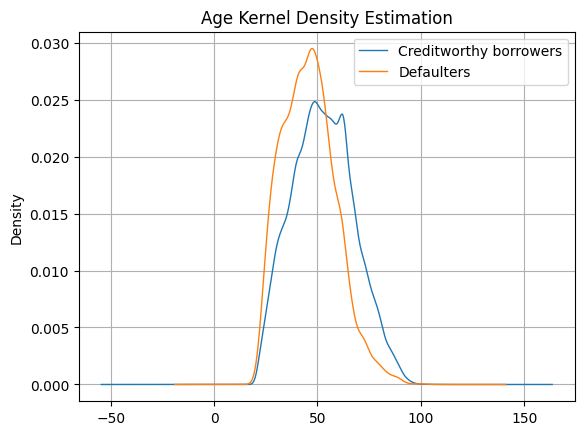

In [14]:
df_train[df_train.SeriousDlqin2yrs==0]['age'].plot.kde(linewidth=1)
df_train[df_train.SeriousDlqin2yrs==1]['age'].plot.kde(linewidth=1)

plt.grid()
plt.legend(['Creditworthy borrowers', 'Defaulters'])
plt.title('Age Kernel Density Estimation')

Age seems well shaped, without particular outliers. Age zero is an outlier. Age seems to be inversely correlated with defaults and this is somewhat common for several reasons.

- Income Stability: younger individuals may have less stable income, making it harder to keep up with payments.
- Credit History Length: older individuals often have longer credit histories, providing more data for lenders to assess creditworthiness.
- Financial Experience: older individuals typically have more experience managing finances and may have developed better financial habits.
- Asset Accumulation: Older individuals may have accumulated assets over time, providing a financial buffer during tough times.

## NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate

Borrowers with a history of late payments are more likely to default in the future. For what concerns past due variables, we will have a deeper look at the tail distribution in order to understand better the nature of possible outliers.
Basically we will fix a 0.995 percentile and investigate further through plot and statistics.

count   150000.00
mean         0.42
std          4.19
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         98.00
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
count   150000.00
mean         0.24
std          4.16
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         98.00
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64
count   150000.00
mean         0.27
std          4.17
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         98.00
Name: NumberOfTimes90DaysLate, dtype: float64


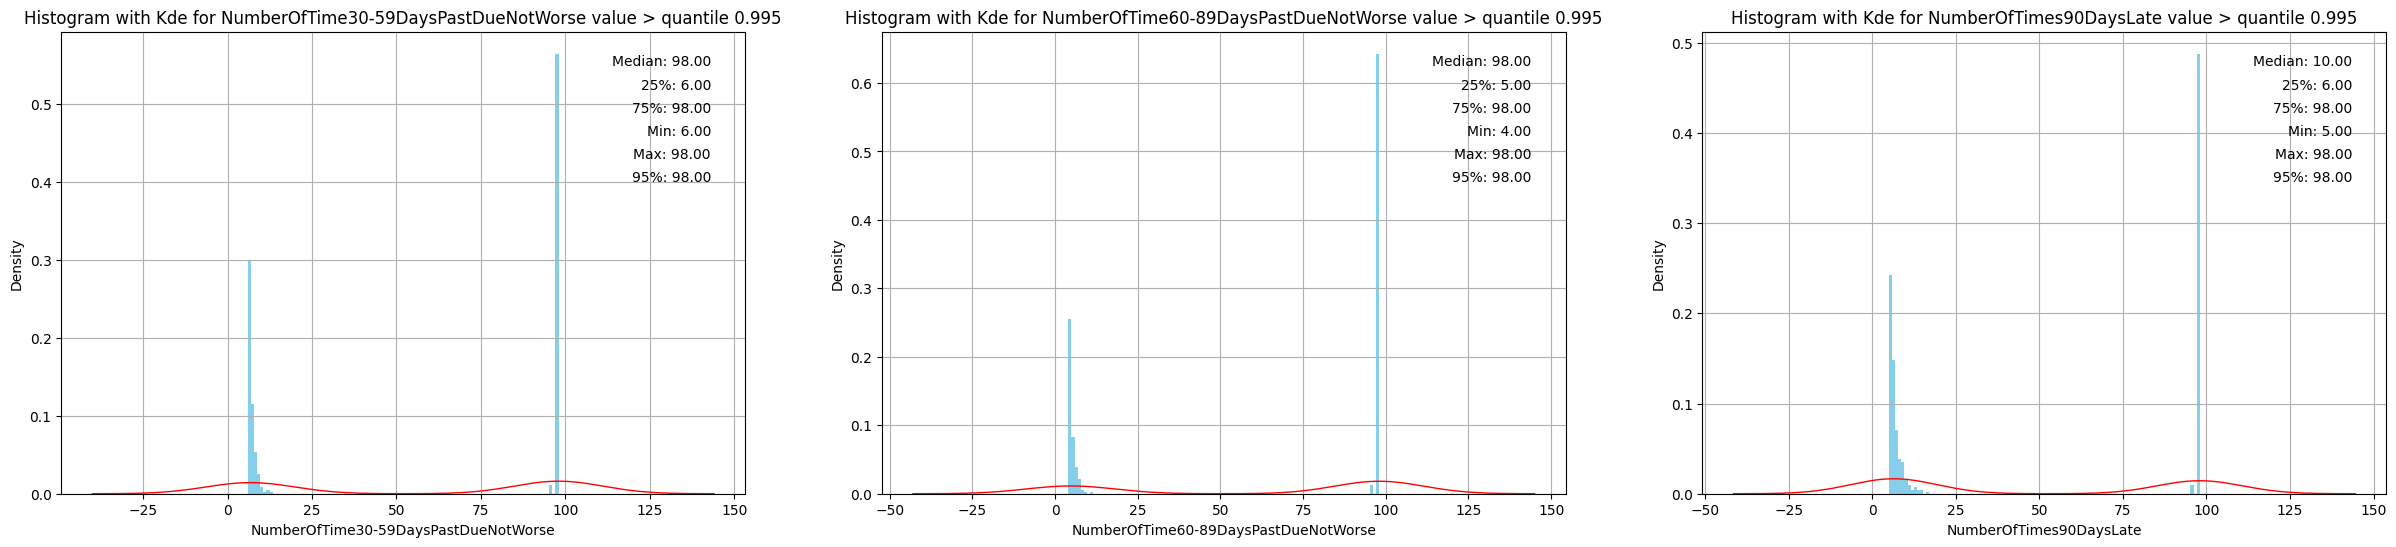

In [15]:
fig, axes = plt.subplots(1,3, figsize=(30, 6))
past_due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']

for n, col in enumerate(past_due_cols):
    # Feature
    alpha = 0.005

    print(df_train[col].describe())
    
    q = df_train[col].quantile(1-alpha)
    s = df_train[df_train[col]>q][col]
    
    # Histogram with KDE
    axes[n].hist(s, bins=100, color='skyblue', density=True, label='Data')
    s.plot(kind='kde', ax=axes[n], color='red', linewidth=1)
    axes[n].set_title(f'Histogram with Kde for {col} value > quantile {1-alpha}')
    axes[n].set_xlabel(col)
    axes[n].grid(True)

    axes[n].text(0.95, 0.95, f'Median: {s.median():.2f}', ha='right', va='top', transform=axes[n].transAxes)
    axes[n].text(0.95, 0.90, f'25%: {s.quantile(0.25):.2f}', ha='right', va='top', transform=axes[n].transAxes)
    axes[n].text(0.95, 0.85, f'75%: {s.quantile(0.75):.2f}', ha='right', va='top', transform=axes[n].transAxes)
    axes[n].text(0.95, 0.80, f'Min: {s.min():.2f}', ha='right', va='top', transform=axes[n].transAxes)
    axes[n].text(0.95, 0.75, f'Max: {s.max():.2f}', ha='right', va='top', transform=axes[n].transAxes)
    axes[n].text(0.95, 0.70, f'95%: {s.quantile(0.99):.2f}', ha='right', va='top', transform=axes[n].transAxes)



What looks very strange is that there is a "hole" in the distribution of those variables between values around 20 and 90. Let's see how is the default rate for those observation.

In [16]:
for c in past_due_cols:
    default = df_train.loc[df_train[c]>96, 'SeriousDlqin2yrs'].mean()
    print(f'Proportion of default in 2 years when {c} > 96: {default}')

Proportion of default in 2 years when NumberOfTime30-59DaysPastDueNotWorse > 96: 0.5416666666666666
Proportion of default in 2 years when NumberOfTime60-89DaysPastDueNotWorse > 96: 0.5416666666666666
Proportion of default in 2 years when NumberOfTimes90DaysLate > 96: 0.5416666666666666


Observations that at first sights can be considered as outliers are both late in the three time horizons. Those points might not be an error as these people are defaulting at a much higher rate than population (55%). Therefore considering data imbalance, better not to throw away these observation and, instead, windsorize them with a value of 6 which is approximately 25% of tail distribution (we refer to the distribution of values after 0.995 quantile).

In [17]:
# Windsoring
for c in past_due_cols:
    df_train.loc[df_train[c]>=96, c] = 6

## Debt Ratio

Debt Ratio may be an indicator of the financial distress of the borrower. However in this context, we notice very strange values.

In [18]:
df_train.DebtRatio.describe()

count   150000.00
mean       353.01
std       2037.82
min          0.00
25%          0.18
50%          0.37
75%          0.87
max     329664.00
Name: DebtRatio, dtype: float64

In [19]:
df_train.DebtRatio.quantile(0.85) 

269.1499999999942

Approximately 15% of records in dataset owns 270 times more than they earn. Let's investigate further

In [20]:
debt_ratio_relevant_col = ['SeriousDlqin2yrs', 'DebtRatio', 'MonthlyIncome']
df_train.loc[df_train.DebtRatio > df_train.DebtRatio.quantile(0.85), debt_ratio_relevant_col].describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,22500.00,0.06,0.23,0.00,0.00,0.00,0.00,1.00
DebtRatio,22500.00,2328.14,4805.50,270.00,1003.00,1803.00,2890.25,329664.00
MonthlyIncome,1497.00,0.27,0.51,0.00,0.00,0.00,1.00,10.00


Those values are probably due to an input error related to Monthly Income, which is NaN, 0, 1 and more generally below 10. Since those records are 15% we cannot drop them. Looking at the default rate, we see that it is aligned with the full sample proportion. Those rate may be wrong or missing since people are not fully disclosing it.
Therefore we windsorize the value the 0.85 percentile. (We tried different value of the percentile and for lower values we see more reasonable values for monthly income).


In [21]:
df_train.loc[df_train.DebtRatio > df_train.DebtRatio.quantile(0.85), 'DebtRatio'] = df_train.DebtRatio.quantile(0.85)

## Monthly Income

Monthly Income is another key indicator for borrower's financial situation.

In [22]:
df_train['MonthlyIncome'].describe()

count    120269.00
mean       6670.22
std       14384.67
min           0.00
25%        3400.00
50%        5400.00
75%        8249.00
max     3008750.00
Name: MonthlyIncome, dtype: float64

 As expected, it looks correlated with the target variable once we separate input data by binary outcome of the target variable (default/no default):

In [23]:
df_train.groupby('SeriousDlqin2yrs')['MonthlyIncome'].describe().T

SeriousDlqin2yrs,0,1
count,111912.00,8357.00
mean,6747.84,5630.83
std,14813.50,6171.72
min,0.00,0.00
25%,3461.00,2963.00
50%,5466.00,4500.00
75%,8333.00,6800.00
max,3008750.00,250000.00


Here we have a look at very high incomes in order to detect potential outliers. Let's group higher aggregating by intervals.

In [24]:
pd.cut(df_train[df_train.MonthlyIncome > 8500]['MonthlyIncome'], bins=5).value_counts()

MonthlyIncome
(5500.751, 608550.8]      27646
(608550.8, 1208600.6]         7
(1208600.6, 1808650.4]        2
(2408700.2, 3008750.0]        1
(1808650.4, 2408700.2]        0
Name: count, dtype: int64

In [25]:
df_train[df_train.MonthlyIncome > 608550.8].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,0.00,0.12,56.40,0.20,0.00,1168155.00,11.10,0.00,1.50,0.10,1.20
std,0.00,0.14,12.47,0.42,0.00,763099.31,5.26,0.00,1.51,0.32,1.23
min,0.00,0.00,44.00,0.00,0.00,629000.00,3.00,0.00,0.00,0.00,0.00
25%,0.00,0.02,49.25,0.00,0.00,700272.50,8.25,0.00,0.25,0.00,0.00
50%,0.00,0.07,52.00,0.00,0.00,782761.50,10.50,0.00,1.00,0.00,1.00
75%,0.00,0.16,64.00,0.00,0.00,1438200.00,12.00,0.00,2.00,0.00,2.00
max,0.00,0.47,83.00,1.00,0.01,3008750.00,23.00,0.00,4.00,1.00,3.00


In [26]:
# Default Rate when missing monthly income
df_train[df_train.MonthlyIncome.isna()]['SeriousDlqin2yrs'].mean()

0.05613669234132723

Since we see that for those with missing income the default rate is high (and we know that also the debt income ratio is high) we fill the missing value with the 0.25 quantile to be more cautious.

In [27]:
df_train.MonthlyIncome = df_train.MonthlyIncome.fillna(df_train.MonthlyIncome.quantile(0.25))

Monthly Income variable, no outliers are detected. We fill missing values with median.In this case we suppose that is the best guess.

## Number of Dependents

Number of dependents can be an indicator of how much the individual is financially distressed, as a numerous family can be a reason of higher expenses, ceteris paribus.

In [28]:
df_train.NumberOfDependents.value_counts()

NumberOfDependents
0.00     86902
1.00     26316
2.00     19522
3.00      9483
4.00      2862
5.00       746
6.00       158
7.00        51
8.00        24
10.00        5
9.00         5
20.00        1
13.00        1
Name: count, dtype: int64

In [29]:
df_train.NumberOfDependents.isna().sum()/df_train.NumberOfDependents.count() 

0.026862728990388565

In [30]:
df_train.NumberOfDependents = df_train.NumberOfDependents.fillna(df_train.NumberOfDependents.median()) # fill nan with median as here is the best guess

In [31]:
df_train[df_train.NumberOfDependents >= 10].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00
mean,0.00,0.26,46.57,0.57,38.65,6292.00,7.29,0.43,0.57,0.00,11.86
std,0.00,0.35,7.55,0.53,101.64,4159.45,2.87,0.79,0.53,0.00,3.76
min,0.00,0.00,39.00,0.00,0.03,0.00,3.00,0.00,0.00,0.00,10.00
25%,0.00,0.05,41.50,0.00,0.08,4083.00,5.50,0.00,0.00,0.00,10.00
50%,0.00,0.14,44.00,1.00,0.23,6316.00,7.00,0.00,1.00,0.00,10.00
75%,0.00,0.28,50.00,1.00,0.47,8333.00,9.50,0.50,1.00,0.00,11.50
max,0.00,1.00,60.00,1.00,269.15,12896.00,11.00,2.00,1.00,0.00,20.00


Number of Dependents seems to have strange high values. After a deeper investigation we notice that for large families income is above the average, therefore we do not consider them as outliers.

## NumberRealEstateLoansOrLines & NumberOfOpenCreditLinesAndLoans

Both variables seems to have very high values and we will perform windsorization to avoid further loss of data.

In [32]:
for c in ['NumberRealEstateLoansOrLines', 'NumberOfOpenCreditLinesAndLoans']:
    df_train[df_train[c]>df_train[c].quantile(0.99)].index.tolist()

## Cleaning data

We tried to remove the minumum amount of data possible from the dataset, considering the imbalance issue.

In [33]:
original_shape = df_train.shape[0]
df_train = df_train[~df_train.index.isin(outliers_indexes)]
after_outliers_remove_shape = df_train.shape[0]

print(f'Percentage outliers removed: {1-after_outliers_remove_shape/original_shape}')

Percentage outliers removed: 0.0017000000000000348


## Correlation Analysis

In this section we analyze, using partial statistics and correlation plots, the impact that the cleaned features have on the target variable we need to model. We notice that some of the features' distribution have substantially different shapes if we separate the dataset between good and bad borrowers.

In [34]:
#Partial Stats
mode = lambda x: x.mode()
mode.__name__ = 'mode'

partial_stats_dict = {
    'RevolvingUtilizationOfUnsecuredLines': 'mean',
    'age': 'mean',	
    'NumberOfTime30-59DaysPastDueNotWorse': 'mean',	
    'DebtRatio': 'median',	
    'MonthlyIncome': 'mean',
    'NumberOfOpenCreditLinesAndLoans': mode,	
    'NumberOfTimes90DaysLate': 'mean',	
    'NumberRealEstateLoansOrLines': mode,
    'NumberOfTime60-89DaysPastDueNotWorse': 'mean',
    'NumberOfDependents':mode	
}
df_partial_stats = df_train.groupby('SeriousDlqin2yrs').agg(partial_stats_dict).T
df_partial_stats['Statistic'] = [partial_stats_dict[i] if isinstance(partial_stats_dict[i], str) else partial_stats_dict[i].__name__ for i in df_partial_stats.index]
df_partial_stats

SeriousDlqin2yrs,0,1,Statistic
RevolvingUtilizationOfUnsecuredLines,0.29,0.71,mean
age,52.76,45.93,mean
NumberOfTime30-59DaysPastDueNotWorse,0.20,1.04,mean
DebtRatio,0.36,0.43,median
MonthlyIncome,6074.72,5260.81,mean
NumberOfOpenCreditLinesAndLoans,6.00,5.00,mode
NumberOfTimes90DaysLate,0.06,0.74,mean
NumberRealEstateLoansOrLines,0.00,0.00,mode
NumberOfTime60-89DaysPastDueNotWorse,0.05,0.48,mean
NumberOfDependents,0.00,0.00,mode


**Spearman's Rank Correlation**

Spearman's rank correlation coefficient (ρ) is a non-parametric measure that assesses the strength and direction of the monotonic relationship between two ranked variables. 
We opted for this approch for the following reasons:
- Spearman's correlation does not assume a linear relationship or a normal distribution of the variables. This makes it more robust for data that do not meet these assumptions.

- Instead of using the raw data values, Spearman's correlation works with the ranks of the data points. This means it evaluates how well the relationship between two variables can be described using a monotonic function.

**Formula:** 

$\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}$

where $d_i$ is the difference between the ranks of each pair of observations and \(n\) is the number of observations.



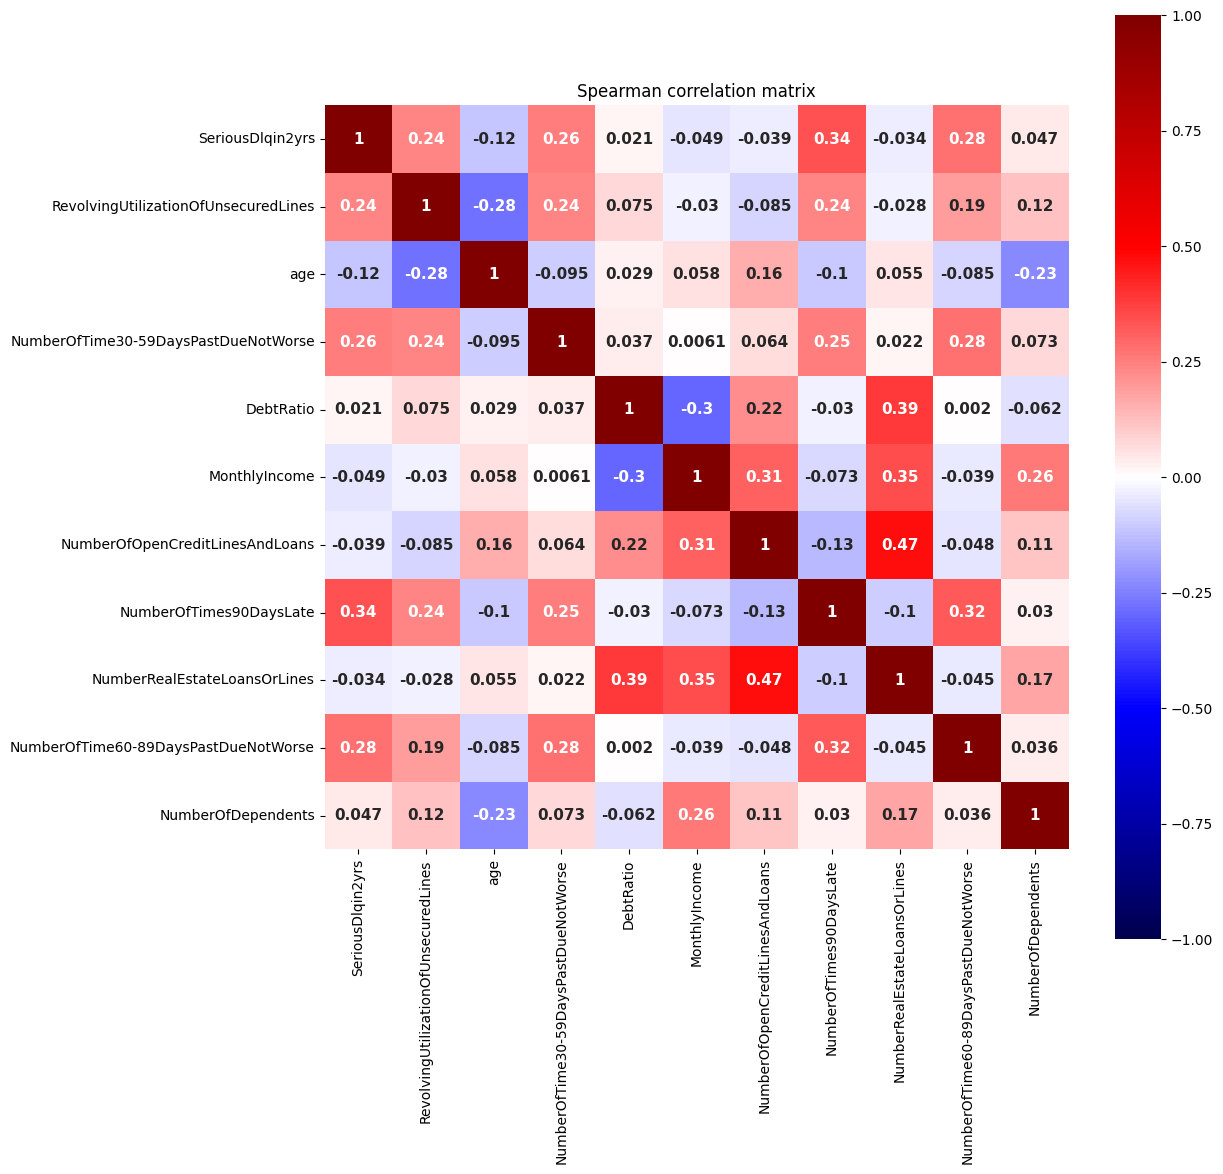

In [35]:
corr = df_train.corr(method='spearman')
plt.figure(figsize = (12,12))
h_map = sns.heatmap(corr, cmap = 'seismic', vmin = -1, vmax = 1, annot = True, square = True,
            annot_kws = {'fontsize': 11, 'fontweight':'bold'})
plt.title('Spearman correlation matrix')
plt.show()

Having a look at overall correlation we notice a couple of things:

- Features are moderately correlated among them
- Features have not an relevant stand-alone impact on Default Rate (the higher is # of time 90 days late)

This emphasizes the need to exploit a model that manages collinearity and describe well possibly non-linear relationships between variables and target.


## Model (Lazy Testing using models with default parameters)

As seen before, data is highly imbalanced. The idea is to use a model that can treat well collinearity, data imbalance and possibly treat outliers in a robust way. 
We test some models with a specific focus on decision trees as they can handle imbalanced data well due to several inherent characteristics.

- ### Non-parametric Nature

  Decision trees are non-parametric models and make no assumptions about the underlying distribution of the data. They partition the feature space based on the training data, which allows them to adapt to the data distribution without being influenced by the class imbalance.

- ### Splitting Criteria
  
  Decision trees use splitting criteria (e.g., Gini impurity, entropy) to determine the best feature to split on at each node. These criteria are sensitive to the distribution of classes within the data, making decision trees naturally inclined to prioritize splits that separate the minority class instances, thus addressing the data imbalance.

- ### Recursive Partitioning:

  Decision trees recursively split the data based on the values of features, which allows them to create regions in the feature space where the minority class instances are more concentrated. This enables decision trees to learn decision boundaries that can effectively separate the minority class from the majority class.

- ### Ensemble Methods:

  Ensemble methods like Random Forests and Gradient Boosting Machines, which are based on decision trees, further enhance the ability to handle imbalanced data. Random Forests, for example, build multiple decision trees on bootstrap samples of the data and combine their predictions, which helps in mitigating the effects of class imbalance.


In [36]:
# Define data and test (validation) size
X = df_train[df_train.columns[1:]]
y = df_train[df_train.columns[:1]]
test_size = .2 # This means that 20% of the data is used for testing


In [37]:
# Perform lazy training
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
classifiers = [DummyClassifier, LogisticRegressionCV, LinearSVC, RandomForestClassifier, GradientBoostingClassifier]
clf = LazyClassifier(random_state=42,
                     ignore_warnings=True,
                     verbose=True,
                     custom_metric=None,
                     classifiers=classifiers)

models, _ = clf.fit(X_train_val, X_test_val, y_train_val, y_test_val)
models



  0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

{'Model': 'DummyClassifier', 'Accuracy': 0.9370596681024408, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.9066120533544859, 'Time taken': 0.08410286903381348}


 40%|████████████████████████████████████▍                                                      | 2/5 [00:03<00:05,  1.71s/it]

{'Model': 'LogisticRegressionCV', 'Accuracy': 0.9404988480416708, 'Balanced Accuracy': 0.5634465480946922, 'ROC AUC': 0.5634465480946923, 'F1 Score': 0.9218259347999576, 'Time taken': 3.3357434272766113}


 60%|██████████████████████████████████████████████████████▌                                    | 3/5 [00:29<00:23, 11.94s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.9394303649537548, 'Balanced Accuracy': 0.5433290126546674, 'ROC AUC': 0.5433290126546674, 'F1 Score': 0.9175572604436552, 'Time taken': 26.2555091381073}


 80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [01:20<00:26, 26.50s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9372266185849277, 'Balanced Accuracy': 0.5824851268340043, 'ROC AUC': 0.5824851268340042, 'F1 Score': 0.9228071888442644, 'Time taken': 50.976399183273315}


100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:55<00:00, 23.07s/it]

{'Model': 'GradientBoostingClassifier', 'Accuracy': 0.9404988480416708, 'Balanced Accuracy': 0.5916542030493392, 'ROC AUC': 0.5916542030493392, 'F1 Score': 0.9261828738866805, 'Time taken': 34.6900897026062}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GradientBoostingClassifier,0.94,0.59,0.59,0.93,34.69
RandomForestClassifier,0.94,0.58,0.58,0.92,50.98
LogisticRegressionCV,0.94,0.56,0.56,0.92,3.34
LinearSVC,0.94,0.54,0.54,0.92,26.26
DummyClassifier,0.94,0.50,0.50,0.91,0.08


After "lazy testing" using some trivial ML models (i.e. we used an automated framework relying on class default parameters), the idea is to use Random Forest as they are robust to outliers and implicitly handles class imbalance by constructing multiple decision trees from bootstrapped samples of the data. This helps mitigate the bias towards the majority class and can lead to more balanced decision boundaries. Logistic CV (cross validated), SVM, and Gradient Boosted Trees would require undersampling procedure which may lead to excessive data loss. Plus the latter also is more computationally expensive. 

##  Random Forest Classifier

We will perform hyper parameter tuning using a grid search approach combined with a stratified k-fold cross validation technique.

In [38]:
%%time
k_fold = 5
n_jobs = 4
filepath = pt.Path(f'models/best_rf_model_{k_fold}_fold.pkl')

if not os.path.exists(filepath):
    # Train and save the GridSearchCV object
    
    # Define the Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=42) # max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
    
    # Define hyperparameters for grid search
    param_grid = {
        'n_estimators': [300, 350],
        'max_depth': [10, 15],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [4, 6, 8]
    }
    
    # Perform grid search with cross-validation
    cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42) # This ensures that each fold has a balanced representation of each class
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, scoring='roc_auc', n_jobs=n_jobs)
    grid_search.fit(X_train_val, y_train_val)

    print('Best score: ', grid_search.best_score_)
    
    best_rf_model = grid_search.best_estimator_

    # Save the best model
    with open(filepath, 'wb') as file:
        pickle.dump(best_rf_model, file)
else:
    # Load the saved GridSearchCV object
    with open(filepath, 'rb') as file:
        best_rf_model = pickle.load(file)

Best score:  0.8648380254916417
CPU times: total: 2min 27s
Wall time: 1h 3min 49s


In [39]:
best_rf_model

RandomForestClassifier(max_depth=15, min_samples_leaf=8, min_samples_split=5,
                       n_estimators=350, random_state=42)

In our credit default prediction problem, the goal is to determine whether a person will default on their loan within the next two years. The ROC AUC curve will help us evaluate how well our model can distinguish between individuals who will default on their loans within two years (positive cases) and those who will not (negative cases).

True Positive Rate (TPR) represents the proportion of individuals correctly identified as likely to default out of all individuals who actually default within two years. In other words, it measures how effectively the model detects individuals who will default on their loans. On the other hand, False Positive Rate (FPR) represents the proportion of individuals incorrectly identified as likely to default out of all individuals who do not default within two years. It measures the rate of false alarms or incorrect predictions of default. 

By plotting the TPR against the FPR for different thresholds of the model, the ROC AUC curve gives us a visual representation of how well the model distinguishes between individuals who will default and those who will not. The area under the ROC curve (AUC) quantifies the overall performance of the model in predicting credit defaults. A higher AUC value (closer to 1) indicates better performance, meaning the model is better at identifying individuals who will default while minimizing false predictions of default.

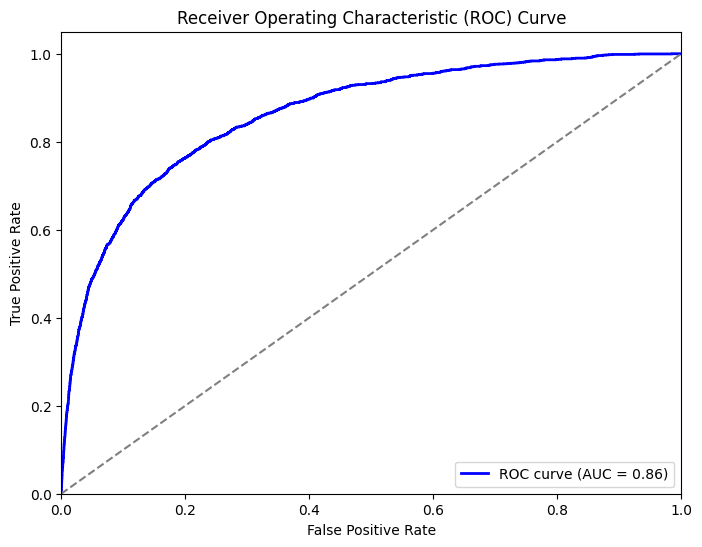

In [40]:
# Predict probabilities for the test set
y_proba_val = best_rf_model.predict_proba(X_test_val)[:, 1] # probability of the positive class 

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_val, y_proba_val)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

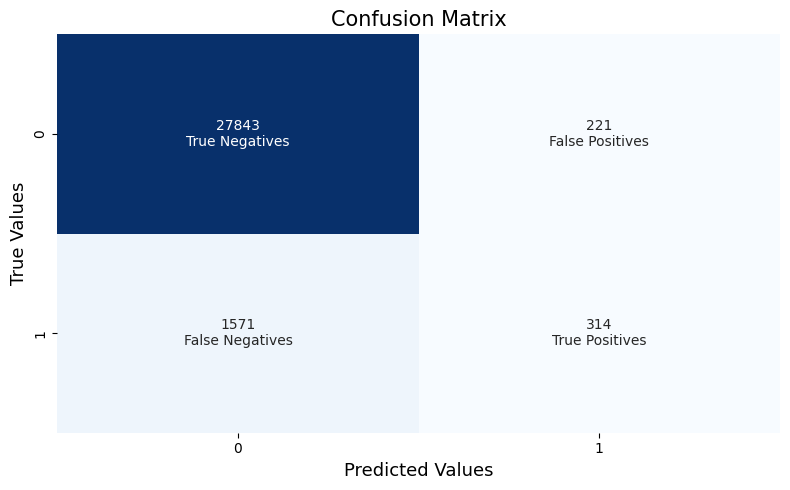

In [41]:
# Use the best model obtained from grid search
y_pred_val = best_rf_model.predict(X_test_val)

# Confusion matrix
cm = confusion_matrix(y_test_val, y_pred_val)

# Increase the figure size
plt.figure(figsize=(8, 5))

# Plot the confusion matrix
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
            annot_kws={"size": 10}, fmt='g')

cmlabels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']

for i,t in enumerate(ax.texts):
    t.set_text(t.get_text() + "\n" + cmlabels[i])

plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Values', size=13)
plt.ylabel('True Values', size=13)
plt.tight_layout()
plt.show()


## Recap on classification metrics
Precision is the ratio of correctly predicted positive observations to the total predicted positives.
- $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$


Recall (also known as sensitivity or true positive rate) is the ratio of correctly predicted positive observations to all actual positives.
- $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

Accuracy is the ratio of correctly predicted observations (both true positives and true negatives) to the total observations.
- $\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Instances}}$

The F1-Score is the harmonic mean of precision and recall, providing a single metric that balances both concerns.
- $\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$


In [42]:
# Generate classification report
report = classification_report(y_test_val, y_pred_val, output_dict=True)
print(f"Accuracy is: {report['accuracy']}")
print('')
print(f"Classification Report: ")
pd.DataFrame(report).transpose().drop(index='accuracy')



Accuracy is: 0.9401649470766971

Classification Report: 


,precision,recall,f1-score,support
0,0.95,0.99,0.97,28064.00
1,0.59,0.17,0.26,1885.00
macro avg,0.77,0.58,0.61,29949.00
weighted avg,0.92,0.94,0.92,29949.00


## Train set - Prediction and Feature Importance

In [43]:
df_test.info()
df_test.MonthlyIncome.fillna(df_test.MonthlyIncome.median(), inplace=True)
df_test.NumberOfDependents.fillna(df_test.NumberOfDependents.median(), inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         81400 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    98877 non-null   float64
dtypes: fl

In [44]:
X_test = df_test[df_test.columns[1:]]
X_test

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,0.89,43,0,0.18,5700.00,4,0,0,0,0.00
2,0.46,57,0,0.53,9141.00,15,0,4,0,2.00
3,0.04,59,0,0.69,5083.00,12,0,1,0,2.00
4,0.28,38,1,0.93,3200.00,7,0,2,0,0.00
5,1.00,27,0,0.02,3865.00,4,0,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...
101499,0.28,24,0,0.07,1400.00,5,0,0,0,0.00
101500,0.92,36,3,0.93,7615.00,8,0,2,0,4.00
101501,0.08,70,0,836.00,5400.00,3,0,0,0,0.00
101502,0.34,56,0,3568.00,5400.00,8,0,2,1,3.00


In [45]:
%%time
# Retrain the model on the full dataset (train + validation set)
best_rf_model.fit(X,y)


CPU times: total: 2min 50s
Wall time: 2min 52s


RandomForestClassifier(max_depth=15, min_samples_leaf=8, min_samples_split=5,
                       n_estimators=350, random_state=42)

Feature importance in Random Forests quantifies the contribution of each feature to the model's predictions. It measures how much each feature decreases the impurity (or increases the information gain) when making decisions in the trees of the forest. Features with higher importance values are deemed more influential in predicting the target variable, while those with lower values are considered less influential.

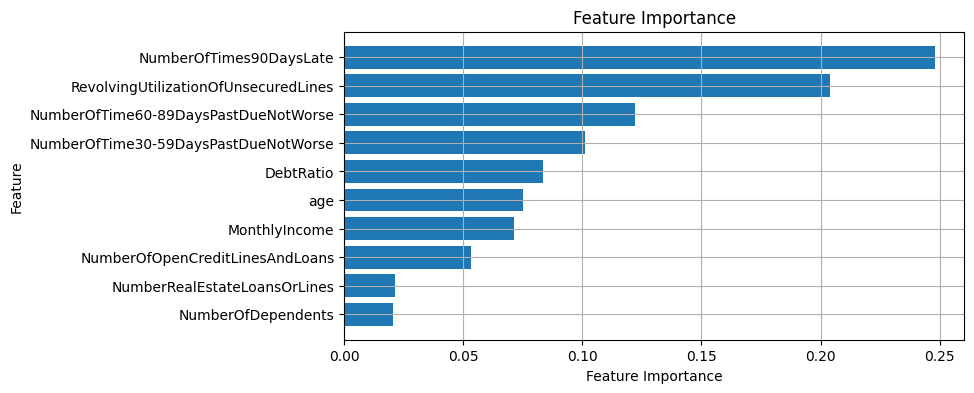

In [46]:
# Feature Importance
feature_importance = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

feature_names = X.columns.tolist()

plt.figure(figsize=(8, 4))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_importance)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.grid(True)
plt.show()

Number of times borrower has been past due and revolving utilization of unsecured lines are the most relevant variables to discriminate a borrower's default in 2y. This is reasonable for a variety of reasons.

- Past behavior often predicts future behavior, and a pattern of delinquencies signals financial instability or poor financial management. 

- Each instance of being past due negatively affects the borrower's credit score as multiple delinquencies suggest a higher risk profile to lenders.

- More severe delinquencies (90 days) have a greater negative impact.

Notice that variables such as number of credit lines, loans or number of dependents have a smaller impact. Those variables represent an indirect measure of financial burden rather than a direct indicator of financial behavior. They provide context about a borrower's potential expenses but doesn't directly reflect their credit management or payment patterns. For example a borrower can be "leveraged" but able to manage his finances or he has high income.


# Saving results

In [47]:
df_test['Probability'] = best_rf_model.predict_proba(X_test)[:,1]

In [48]:
results = df_test['Probability'].reset_index().rename(columns={'index': 'Id'})

In [49]:
results

,Id,Probability
0,1,0.07
1,2,0.03
2,3,0.01
3,4,0.06
4,5,0.13
...,...,...
101498,101499,0.03
101499,101500,0.37
101500,101501,0.01
101501,101502,0.11


In [50]:
results.to_csv(pt.Path('output/results.csv'), index=False)